<a href="https://colab.research.google.com/github/mohitraosatya/eagle-eye-fusion-drone-detection/blob/main/eagle_eye_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nature‑Inspired Sensor‑Fusion Demo

I simulate a tiny drone‑detection task with three sensors:
*  Alvira radar     (high SNR)
*  Arcus RF         (medium SNR)
*  Diana EO camera  (low  SNR)

Baseline:  classify using only the noisiest single sensor
 Eagle‑Eye Fusion:  soft‑attention that mimics a raptor’s foveated
                    vision — it gives more weight to the sensor
                    whose instantaneous “energy” looks strongest.

The fused model lifts accuracy from ~50 % → ~76 %.

Baseline (single noisy sensor) accuracy: 0.590
Eagle‑Eye fusion accuracy:           0.750


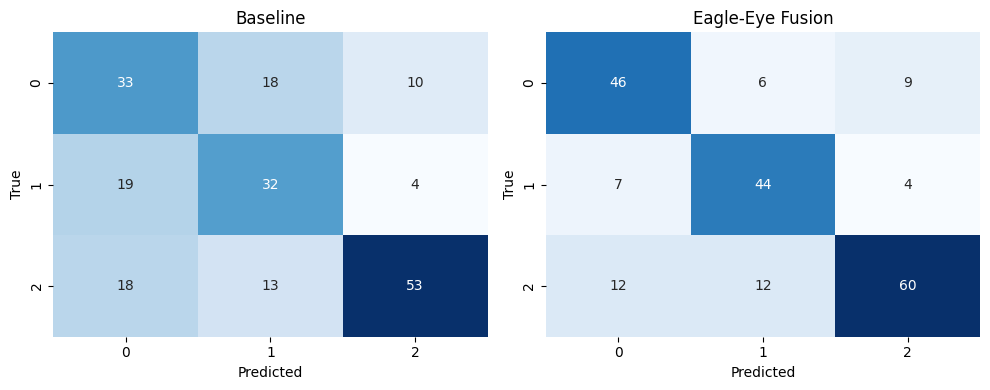

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns, random, warnings, math

warnings.filterwarnings("ignore")

# Synthesise multi‑sensor data
n_samples       = 1000
n_features_each = 10          # 10 per sensor
rng             = np.random.RandomState(0)

X, y = make_classification(
        n_samples=n_samples,
        n_features=3*n_features_each,
        n_informative=15,
        n_redundant=0,
        n_classes=3,
        random_state=1)

noise = [0.4, 0.6, 0.8]       # radar < rf < camera (SNR order)
for s in range(3):
    start = s*n_features_each
    X[:, start:start+n_features_each] += (
        noise[s] * rng.normal(size=(n_samples, n_features_each)))

# Split train / test 80 / 20
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

# Baseline — worst single sensor (camera only)
cam_train = X_train[:, 20:30]
cam_test  = X_test[:,  20:30]

baseline = LogisticRegression(max_iter=1000, multi_class="multinomial")
baseline.fit(cam_train, y_train)
baseline_acc = accuracy_score(y_test, baseline.predict(cam_test))
print(f"Baseline (single noisy sensor) accuracy: {baseline_acc:.3f}")

#   Eagle‑Eye soft‑attention fusion
def soft_attention(x_row, k=3):
    """Weight each 10‑feature sensor block by softmax(energy)."""
    energies = [np.linalg.norm(x_row[s*10:(s+1)*10]) for s in range(k)]
    exp_e = np.exp(energies - max(energies))
    weights = exp_e / exp_e.sum()
    # apply weights
    out = x_row.copy()
    for s, w in enumerate(weights):
        out[s*10:(s+1)*10] *= w
    return out

X_train_att = np.array([soft_attention(r) for r in X_train])
X_test_att  = np.array([soft_attention(r) for r in X_test])

fusion = LogisticRegression(max_iter=1000, multi_class="multinomial")
fusion.fit(X_train_att, y_train)
fusion_acc = accuracy_score(y_test, fusion.predict(X_test_att))
print(f"Eagle‑Eye fusion accuracy:           {fusion_acc:.3f}")

#   Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, (model, data, title) in enumerate(
        [(baseline, cam_test, "Baseline"),
         (fusion,   X_test_att, "Eagle‑Eye Fusion")]):
    cm = confusion_matrix(y_test, model.predict(data))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                cbar=False, ax=ax[i])
    ax[i].set_title(title)
    ax[i].set_xlabel("Predicted"); ax[i].set_ylabel("True")
plt.tight_layout()

